# 05_集成学习 - GLP-1临床试验风险预测

## 📊 功能概述

本notebook实现集成学习建模功能，使用多种机器学习算法构建风险预测模型：

1. **数据准备** - 加载带标签的特征数据并进行预处理
2. **模型训练** - 训练多种基础模型（逻辑回归、随机森林、梯度提升、SVM）
3. **模型评估** - 使用交叉验证和测试集评估模型性能
4. **集成学习** - 实现加权集成和堆叠集成
5. **模型解释** - 使用SHAP分析解释模型预测（优化版：背景抽样，跳过SVM）
6. **结果保存** - 保存模型和评估结果

## 🚀 运行说明

直接运行所有单元格即可完成集成学习建模。

**输入文件**: `processed_data/glp1_18clinical_features_with_labels_correct.csv`  
**输出文件**: 
- `models/` - 保存训练好的模型文件
- `results/model_performance_report.csv` - 模型性能报告
- `results/shap_analysis_results.csv` - SHAP分析结果
- `results/feature_importance.png` - 特征重要性图

## 📝 学习目标

通过本notebook，您将学习：
- 如何构建和评估多种机器学习模型
- 集成学习的基本原理和实现方法
- 模型性能评估的指标和方法
- 使用SHAP进行模型解释和特征重要性分析（优化版）

## 🎯 建模策略

本notebook采用以下建模策略：
- **基础模型**: 逻辑回归、随机森林、梯度提升、SVM
- **集成方法**: 加权集成和堆叠集成
- **评估方法**: 5折交叉验证和测试集评估
- **不平衡处理**: 使用SMOTE处理类别不平衡
- **模型解释**: SHAP分析（背景抽样优化，跳过SVM）提供可解释性

## 1. 导入必要的库

**📝 讲解**: 集成学习需要多种机器学习和数据分析库的支持：

- **pandas, numpy**: 数据处理和数值计算
- **sklearn**: 机器学习算法和评估工具
- **imblearn**: 不平衡数据处理（SMOTE）
- **shap**: 模型解释和特征重要性分析
- **matplotlib, seaborn**: 数据可视化
- **joblib**: 模型保存和加载

**💡 技术要点**: 
- 设置中文字体确保图表正确显示中文
- 设置随机种子确保结果可重现
- 添加项目路径确保模块导入正确

In [1]:
# 导入集成学习所需的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
from datetime import datetime
import joblib
import matplotlib.font_manager as fm

# 机器学习库
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# 不平衡数据处理
from imblearn.over_sampling import SMOTE

# 模型解释
import shap

# ========== 中文字体配置（增强版）==========
print("🔧 设置中文字体配置...")

chinese_font_names = [
    'SimHei', 'Microsoft YaHei',          # Windows
    'PingFang SC', 'STHeiti',              # macOS
    'WenQuanYi Zen Hei', '文泉驿正黑',      # Linux
    'Noto Sans CJK SC', 'Droid Sans Fallback'
]

available_fonts = [f.name for f in fm.fontManager.ttflist]
selected_font = None
for font in chinese_font_names:
    if font in available_fonts:
        selected_font = font
        break

if selected_font is None:
    print("⚠️ 未找到已知中文字体，中文可能无法正确显示，将使用系统默认 sans-serif 字体。")
    selected_font = 'sans-serif'
else:
    print(f"✅ 找到可用中文字体: {selected_font}")

plt.rcParams['font.sans-serif'] = [selected_font] + plt.rcParams['font.sans-serif']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style('whitegrid')
plt.rcParams['font.sans-serif'] = [selected_font] + [f for f in plt.rcParams['font.sans-serif'] if f != selected_font]
plt.rcParams['axes.unicode_minus'] = False

print("✅ 字体配置完成")
print(f"📋 最终字体列表: {plt.rcParams['font.sans-serif']}")
print(f"📋 负号显示: {plt.rcParams['axes.unicode_minus']}")
# ==========================================

# 设置随机种子确保结果可重现
np.random.seed(42)

# 忽略警告
warnings.filterwarnings('ignore')

# 添加项目根目录到路径，确保可以导入项目中的其他模块
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('.'))))

print("✅ 库导入完成")
print(f"当前工作目录: {os.getcwd()}")
print(f"Pandas版本: {pd.__version__}")
print(f"NumPy版本: {np.__version__}")
print(f"处理开始时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

🔧 设置中文字体配置...
✅ 找到可用中文字体: SimHei
✅ 字体配置完成
📋 最终字体列表: ['SimHei', 'Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']
📋 负号显示: False
✅ 库导入完成
当前工作目录: d:\projects\glp1-trial-risk-prediction\glp1-risk-prediction\notebooks
Pandas版本: 2.3.3
NumPy版本: 2.2.6
处理开始时间: 2026-02-27 21:58:01


## 2. 加载带标签的数据

**📝 讲解**: 加载由标签定义脚本生成的带标签特征数据：

- 检查带标签数据文件是否存在
- 加载数据并进行基本的数据质量检查
- 显示数据的基本信息和标签分布
- 检查数据不平衡情况

**💡 技术要点**: 
- 使用`os.path.exists()`检查文件存在性
- 使用`value_counts()`统计标签分布
- 计算不平衡比例评估数据质量

In [2]:
# 检查带标签数据是否存在
labeled_file = os.path.join('..', 'processed_data', 'glp1_18clinical_features_with_labels_correct.csv')

if not os.path.exists(labeled_file):
    print("❌ 带标签数据不存在，请先运行04_标签定义_正确方法.ipynb")
else:
    print("✅ 带标签数据存在，开始加载...")
    
    # 加载带标签数据
    df = pd.read_csv(labeled_file)
    
    print(f"✅ 带标签数据加载完成!")
    print(f"加载数据: {df.shape[0]} 行, {df.shape[1]} 列")
    
    # 显示数据基本信息
    print(f"\n📋 数据基本信息:")
    print(df.info())
    
    # 显示数据前5行
    print(f"\n📊 数据前5行:")
    display(df.head())
    
    # 显示标签分布
    print(f"\n📊 风险标签分布:")
    label_counts = df['risk_label'].value_counts()
    total_trials = len(df)
    
    for label, count in label_counts.items():
        label_name = '高风险' if label == 1 else '低风险'
        percentage = count / total_trials * 100
        print(f"{label_name}: {count} 个试验 ({percentage:.2f}%)")
    
    # 计算不平衡比例
    imbalance_ratio = label_counts[1] / label_counts[0] if label_counts[0] > 0 else float('inf')
    print(f"\n📊 数据不平衡分析:")
    print(f"   不平衡比例: {imbalance_ratio:.3f}")
    print(f"   高风险/低风险: 1:{1/imbalance_ratio:.1f}" if imbalance_ratio > 0 else "   无高风险试验")
    
    # 显示特征列
    feature_columns = [col for col in df.columns if col not in ['nct_id', 'overall_status', 'why_stopped', 'risk_label']]
    print(f"\n📋 特征列列表 ({len(feature_columns)} 个):")
    for i, col in enumerate(feature_columns, 1):
        print(f"{i:2d}. {col}")
    
    # 显示数据类型统计
    print(f"\n📊 数据类型统计:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"{dtype}: {count} 列")

✅ 带标签数据存在，开始加载...
✅ 带标签数据加载完成!
加载数据: 30105 行, 22 列

📋 数据基本信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30105 entries, 0 to 30104
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   nct_id                          30105 non-null  object 
 1   enrollment_log                  30105 non-null  float64
 2   start_year                      30105 non-null  float64
 3   pre_semaglutide_era             30105 non-null  int64  
 4   post_semaglutide_era            30105 non-null  int64  
 5   phase_Unknown                   30105 non-null  int64  
 6   phase_PHASE4                    30105 non-null  int64  
 7   is_obesity                      30105 non-null  int64  
 8   is_t2d                          30105 non-null  int64  
 9   is_weight_loss                  30105 non-null  int64  
 10  exc_count                       30105 non-null  int64  
 11  criteria_total_len             

,nct_id,enrollment_log,start_year,pre_semaglutide_era,post_semaglutide_era,phase_Unknown,phase_PHASE4,is_obesity,is_t2d,is_weight_loss,...,mentions_bmi,mentions_contraindication,mentions_renal_cutoff,high_risk_term_count,risk_ratio,year_x_enrollment,enrollment_log_x_phase_Unknown,overall_status,why_stopped,risk_label
0,NCT00438555,5.517453,2006.0,1,0,0,0,1,0,0,...,1,0,0,0,0.0,11068.010510,0.0,COMPLETED,NaN,0
1,NCT04272073,5.484797,2022.0,0,1,0,0,1,0,0,...,0,0,0,0,0.0,11090.259400,0.0,UNKNOWN,NaN,0
2,NCT03748433,3.583519,2019.0,0,1,0,0,0,0,0,...,0,0,0,1,1.0,7235.124737,0.0,TERMINATED,Terminated early after the interim analysis. I...,1
3,NCT02706067,3.931826,2002.0,1,0,0,0,1,0,1,...,1,1,0,1,1.0,7871.514917,0.0,COMPLETED,NaN,0
4,NCT01740817,2.564949,2008.0,1,0,0,0,1,0,0,...,0,0,1,0,0.0,5150.418310,0.0,COMPLETED,NaN,0



📊 风险标签分布:
低风险: 30000 个试验 (99.65%)
高风险: 105 个试验 (0.35%)

📊 数据不平衡分析:
   不平衡比例: 0.004
   高风险/低风险: 1:285.7

📋 特征列列表 (18 个):
 1. enrollment_log
 2. start_year
 3. pre_semaglutide_era
 4. post_semaglutide_era
 5. phase_Unknown
 6. phase_PHASE4
 7. is_obesity
 8. is_t2d
 9. is_weight_loss
10. exc_count
11. criteria_total_len
12. mentions_bmi
13. mentions_contraindication
14. mentions_renal_cutoff
15. high_risk_term_count
16. risk_ratio
17. year_x_enrollment
18. enrollment_log_x_phase_Unknown

📊 数据类型统计:
int64: 14 列
float64: 5 列
object: 3 列


## 3. 数据预处理

**📝 讲解**: 对数据进行预处理，为建模做准备：

- **特征选择**: 选择数值型特征用于建模
- **数据分割**: 将数据分为训练集和测试集
- **特征缩放**: 使用标准化对特征进行缩放
- **不平衡处理**: 使用SMOTE处理类别不平衡

**💡 技术要点**: 
- 使用`train_test_split()`分割数据
- 使用`StandardScaler()`进行特征标准化
- 使用`SMOTE()`进行过采样处理不平衡数据
- 设置`stratify=y`确保分层抽样

In [3]:
print("🔧 开始数据预处理...")

# 选择特征和目标变量
X = df[feature_columns]
y = df['risk_label']

print(f"特征矩阵维度: {X.shape}")
print(f"目标变量维度: {y.shape}")

# 数据分割（70%训练，30%测试）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\n📊 数据分割结果:")
print(f"训练集: {X_train.shape[0]} 个样本")
print(f"测试集: {X_test.shape[0]} 个样本")
print(f"训练集高风险比例: {y_train.mean():.3f}")
print(f"测试集高风险比例: {y_test.mean():.3f}")

# 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ 特征标准化完成")

# 处理数据不平衡（使用SMOTE）
print(f"\n🔧 处理数据不平衡...")
print(f"SMOTE前训练集标签分布:")
print(f"低风险: {sum(y_train == 0)} 个样本")
print(f"高风险: {sum(y_train == 1)} 个样本")

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"\n✅ SMOTE过采样完成")
print(f"SMOTE后训练集标签分布:")
print(f"低风险: {sum(y_train_resampled == 0)} 个样本")
print(f"高风险: {sum(y_train_resampled == 1)} 个样本")
print(f"平衡比例: 1:1")

# 转换为数据框以便后续使用
X_train_final = pd.DataFrame(X_train_resampled, columns=feature_columns)
X_test_final = pd.DataFrame(X_test_scaled, columns=feature_columns)
y_train_final = y_train_resampled

print(f"\n✅ 数据预处理完成!")
print(f"最终训练集维度: {X_train_final.shape}")
print(f"最终测试集维度: {X_test_final.shape}")

🔧 开始数据预处理...
特征矩阵维度: (30105, 18)
目标变量维度: (30105,)

📊 数据分割结果:
训练集: 21073 个样本
测试集: 9032 个样本
训练集高风险比例: 0.003
测试集高风险比例: 0.004

✅ 特征标准化完成

🔧 处理数据不平衡...
SMOTE前训练集标签分布:
低风险: 21000 个样本
高风险: 73 个样本

✅ SMOTE过采样完成
SMOTE后训练集标签分布:
低风险: 21000 个样本
高风险: 21000 个样本
平衡比例: 1:1

✅ 数据预处理完成!
最终训练集维度: (42000, 18)
最终测试集维度: (9032, 18)


## 4. 定义基础模型

**📝 讲解**: 定义多种基础机器学习模型：

### 基础模型选择

1. **逻辑回归 (Logistic Regression)** - 线性模型，易于解释
2. **随机森林 (Random Forest)** - 集成树模型，鲁棒性强
3. **梯度提升 (Gradient Boosting)** - 提升算法，预测精度高
4. **支持向量机 (SVM)** - 最大间隔分类器

**💡 技术要点**: 
- 设置`class_weight='balanced'`处理不平衡数据
- 设置`random_state=42`确保结果可重现
- 使用字典存储模型便于批量处理

In [4]:
print("🤖 定义基础模型...")

# 定义基础模型
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42, class_weight='balanced')
}

print(f"✅ 定义了 {len(models)} 个基础模型:")
for name, model in models.items():
    print(f"   - {name}: {type(model).__name__}")

# 显示模型参数
print(f"\n📋 模型参数设置:")
for name, model in models.items():
    print(f"{name}:")
    params = model.get_params()
    # 只显示关键参数
    key_params = {k: v for k, v in params.items() if 'random_state' in k or 'n_estimators' in k or 'class_weight' in k}
    for param, value in key_params.items():
        print(f"    {param}: {value}")
    print()

🤖 定义基础模型...
✅ 定义了 4 个基础模型:
   - Logistic Regression: LogisticRegression
   - Random Forest: RandomForestClassifier
   - Gradient Boosting: GradientBoostingClassifier
   - SVM: SVC

📋 模型参数设置:
Logistic Regression:
    class_weight: balanced
    random_state: 42

Random Forest:
    class_weight: balanced
    n_estimators: 100
    random_state: 42

Gradient Boosting:
    n_estimators: 100
    random_state: 42

SVM:
    class_weight: balanced
    random_state: 42



## 5. 训练和评估模型

**📝 讲解**: 训练所有基础模型并评估其性能：

### 评估指标
- **准确率 (Accuracy)**: 正确预测的比例
- **精确率 (Precision)**: 预测为正例中实际为正例的比例
- **召回率 (Recall)**: 实际为正例中预测为正例的比例
- **F1分数 (F1-Score)**: 精确率和召回率的调和平均
- **AUC-ROC**: 受试者工作特征曲线下面积

**💡 技术要点**: 
- 使用5折交叉验证评估模型稳定性
- 使用`zero_division=0`避免除零错误
- 保存所有模型的预测结果用于集成

In [5]:
print("🚀 开始训练和评估模型...")

# 训练模型并评估
model_results = {}

for name, model in models.items():
    print(f"\n📊 训练 {name}...")
    
    # 训练模型
    model.fit(X_train_final, y_train_final)
    
    # 预测
    y_pred = model.predict(X_test_final)
    y_pred_proba = model.predict_proba(X_test_final)[:, 1]
    
    # 计算评估指标
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # 交叉验证
    cv_scores = cross_val_score(model, X_train_final, y_train_final, cv=5, scoring='roc_auc')
    
    # 保存结果
    model_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"✅ {name} 训练完成")
    print(f"   准确率: {accuracy:.3f}")
    print(f"   精确率: {precision:.3f}")
    print(f"   召回率: {recall:.3f}")
    print(f"   F1分数: {f1:.3f}")
    print(f"   AUC: {auc:.3f}")
    print(f"   交叉验证AUC: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

print(f"\n✅ 所有模型训练完成!")

# 显示模型性能比较
print(f"\n📊 模型性能比较:")
performance_df = pd.DataFrame({
    '模型': list(model_results.keys()),
    '准确率': [result['accuracy'] for result in model_results.values()],
    '精确率': [result['precision'] for result in model_results.values()],
    '召回率': [result['recall'] for result in model_results.values()],
    'F1分数': [result['f1'] for result in model_results.values()],
    'AUC': [result['auc'] for result in model_results.values()],
    '交叉验证AUC': [result['cv_mean'] for result in model_results.values()]
}).round(3)

display(performance_df)

# 找出最佳模型
best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['auc'])
best_model_auc = model_results[best_model_name]['auc']
print(f"\n🏆 最佳模型: {best_model_name} (AUC = {best_model_auc:.3f})")

🚀 开始训练和评估模型...

📊 训练 Logistic Regression...
✅ Logistic Regression 训练完成
   准确率: 0.760
   精确率: 0.005
   召回率: 0.344
   F1分数: 0.010
   AUC: 0.667
   交叉验证AUC: 0.816 (±0.003)

📊 训练 Random Forest...
✅ Random Forest 训练完成
   准确率: 0.991
   精确率: 0.020
   召回率: 0.031
   F1分数: 0.024
   AUC: 0.646
   交叉验证AUC: 1.000 (±0.000)

📊 训练 Gradient Boosting...
✅ Gradient Boosting 训练完成
   准确率: 0.944
   精确率: 0.016
   召回率: 0.250
   F1分数: 0.031
   AUC: 0.618
   交叉验证AUC: 0.993 (±0.001)

📊 训练 SVM...
✅ SVM 训练完成
   准确率: 0.917
   精确率: 0.010
   召回率: 0.219
   F1分数: 0.018
   AUC: 0.562
   交叉验证AUC: 0.987 (±0.001)

✅ 所有模型训练完成!

📊 模型性能比较:


,模型,准确率,精确率,召回率,F1分数,AUC,交叉验证AUC
0,Logistic Regression,0.760,0.005,0.344,0.010,0.667,0.816
1,Random Forest,0.991,0.020,0.031,0.024,0.646,1.000
2,Gradient Boosting,0.944,0.016,0.250,0.031,0.618,0.993
3,SVM,0.917,0.010,0.219,0.018,0.562,0.987



🏆 最佳模型: Logistic Regression (AUC = 0.667)


## 6. 集成学习

**📝 讲解**: 实现两种集成学习方法：

### 集成方法
1. **加权集成 (Weighted Ensemble)**: 根据模型性能分配权重
2. **堆叠集成 (Stacking Ensemble)**: 使用元学习器组合基础模型

### 权重计算
- 基于AUC分数计算模型权重
- 归一化权重确保总和为1
- 性能越好的模型权重越高

**💡 技术要点**: 
- 使用加权平均进行集成预测
- 使用逻辑回归作为元学习器
- 比较集成模型与基础模型的性能

In [6]:
print("🔗 开始集成学习...")

# 方法1: 加权集成
print(f"\n📊 方法1: 加权集成")

# 计算模型权重（基于AUC）
auc_scores = {name: result['auc'] for name, result in model_results.items()}
total_auc = sum(auc_scores.values())
weights = {name: auc / total_auc for name, auc in auc_scores.items()}

print(f"模型权重 (基于AUC):")
for name, weight in weights.items():
    print(f"{name}: {weight:.3f}")

# 加权集成预测
weighted_pred_proba = np.zeros(len(y_test))
for name, result in model_results.items():
    weighted_pred_proba += weights[name] * result['y_pred_proba']

weighted_pred = (weighted_pred_proba > 0.5).astype(int)

# 评估加权集成
weighted_accuracy = accuracy_score(y_test, weighted_pred)
weighted_precision = precision_score(y_test, weighted_pred, zero_division=0)
weighted_recall = recall_score(y_test, weighted_pred, zero_division=0)
weighted_f1 = f1_score(y_test, weighted_pred, zero_division=0)
weighted_auc = roc_auc_score(y_test, weighted_pred_proba)

print(f"\n✅ 加权集成评估结果:")
print(f"准确率: {weighted_accuracy:.3f}")
print(f"精确率: {weighted_precision:.3f}")
print(f"召回率: {weighted_recall:.3f}")
print(f"F1分数: {weighted_f1:.3f}")
print(f"AUC: {weighted_auc:.3f}")

# 方法2: 堆叠集成
print(f"\n📊 方法2: 堆叠集成")

# 创建基础模型的预测概率作为新特征
stacking_features_train = np.column_stack([
    result['model'].predict_proba(X_train_final)[:, 1] for result in model_results.values()
])

stacking_features_test = np.column_stack([
    result['model'].predict_proba(X_test_final)[:, 1] for result in model_results.values()
])

# 使用逻辑回归作为元学习器
meta_learner = LogisticRegression(random_state=42)
meta_learner.fit(stacking_features_train, y_train_final)

# 堆叠集成预测
stacking_pred_proba = meta_learner.predict_proba(stacking_features_test)[:, 1]
stacking_pred = meta_learner.predict(stacking_features_test)

# 评估堆叠集成
stacking_accuracy = accuracy_score(y_test, stacking_pred)
stacking_precision = precision_score(y_test, stacking_pred, zero_division=0)
stacking_recall = recall_score(y_test, stacking_pred, zero_division=0)
stacking_f1 = f1_score(y_test, stacking_pred, zero_division=0)
stacking_auc = roc_auc_score(y_test, stacking_pred_proba)

print(f"\n✅ 堆叠集成评估结果:")
print(f"准确率: {stacking_accuracy:.3f}")
print(f"精确率: {stacking_precision:.3f}")
print(f"召回率: {stacking_recall:.3f}")
print(f"F1分数: {stacking_f1:.3f}")
print(f"AUC: {stacking_auc:.3f}")

# 保存集成结果
ensemble_results = {
    'Weighted Ensemble': {
        'accuracy': weighted_accuracy,
        'precision': weighted_precision,
        'recall': weighted_recall,
        'f1': weighted_f1,
        'auc': weighted_auc,
        'y_pred': weighted_pred,
        'y_pred_proba': weighted_pred_proba
    },
    'Stacking Ensemble': {
        'accuracy': stacking_accuracy,
        'precision': stacking_precision,
        'recall': stacking_recall,
        'f1': stacking_f1,
        'auc': stacking_auc,
        'y_pred': stacking_pred,
        'y_pred_proba': stacking_pred_proba
    }
}

print(f"\n✅ 集成学习完成!")
print(f"集成模型数量: {len(ensemble_results)} 个")

# 找出最佳集成模型
best_ensemble_name = max(ensemble_results.keys(), key=lambda x: ensemble_results[x]['auc'])
best_ensemble_auc = ensemble_results[best_ensemble_name]['auc']
print(f"🏆 最佳集成模型: {best_ensemble_name} (AUC = {best_ensemble_auc:.3f})")

# 比较基础模型和集成模型
print(f"\n📊 模型性能对比:")
print(f"最佳基础模型: {best_model_name} (AUC = {best_model_auc:.3f})")
print(f"最佳集成模型: {best_ensemble_name} (AUC = {best_ensemble_auc:.3f})")
improvement = best_ensemble_auc - best_model_auc
print(f"集成提升: {improvement:.3f} AUC")

🔗 开始集成学习...

📊 方法1: 加权集成
模型权重 (基于AUC):
Logistic Regression: 0.267
Random Forest: 0.259
Gradient Boosting: 0.248
SVM: 0.225

✅ 加权集成评估结果:
准确率: 0.970
精确率: 0.027
召回率: 0.219
F1分数: 0.049
AUC: 0.673

📊 方法2: 堆叠集成

✅ 堆叠集成评估结果:
准确率: 0.990
精确率: 0.018
召回率: 0.031
F1分数: 0.023
AUC: 0.592

✅ 集成学习完成!
集成模型数量: 2 个
🏆 最佳集成模型: Weighted Ensemble (AUC = 0.673)

📊 模型性能对比:
最佳基础模型: Logistic Regression (AUC = 0.667)
最佳集成模型: Weighted Ensemble (AUC = 0.673)
集成提升: 0.006 AUC


## 7. 模型解释（SHAP分析 - 优化版）

**📝 讲解**: 使用SHAP分析解释模型预测，理解特征重要性。为提升速度，我们对背景数据进行了抽样（200个样本），并且只对逻辑回归、随机森林、梯度提升三个模型进行加权SHAP分析（跳过SVM，因为其SHAP计算极慢）。

### SHAP分析原理
- **SHAP值**: 每个特征对预测结果的贡献值
- **特征重要性**: 基于SHAP绝对值的均值
- **可解释性**: 提供模型决策的透明解释

### 分析内容
- 计算LR、RF、GB的SHAP值（背景抽样200）
- 按权重加权平均得到集成模型的SHAP值（权重重新归一化）
- 生成特征重要性排名
- 可视化特征重要性

🔍 开始SHAP分析（优化版）...
SHAP模型权重（归一化后）:
Logistic Regression: 0.345
Random Forest: 0.335
Gradient Boosting: 0.320
使用背景样本数: 200
正在处理模型: Logistic Regression, 权重: 0.345
正在处理模型: Random Forest, 权重: 0.335
正在处理模型: Gradient Boosting, 权重: 0.320

✅ 加权SHAP值计算完成
📊 特征重要性排名 (前10):
 1. criteria_total_len: 0.6052
 2. high_risk_term_count: 0.4256
 3. risk_ratio: 0.3520
 4. is_obesity: 0.3019
 5. start_year: 0.1990
 6. post_semaglutide_era: 0.1662
 7. enrollment_log: 0.1567
 8. pre_semaglutide_era: 0.1014
 9. mentions_bmi: 0.0687
10. mentions_contraindication: 0.0654


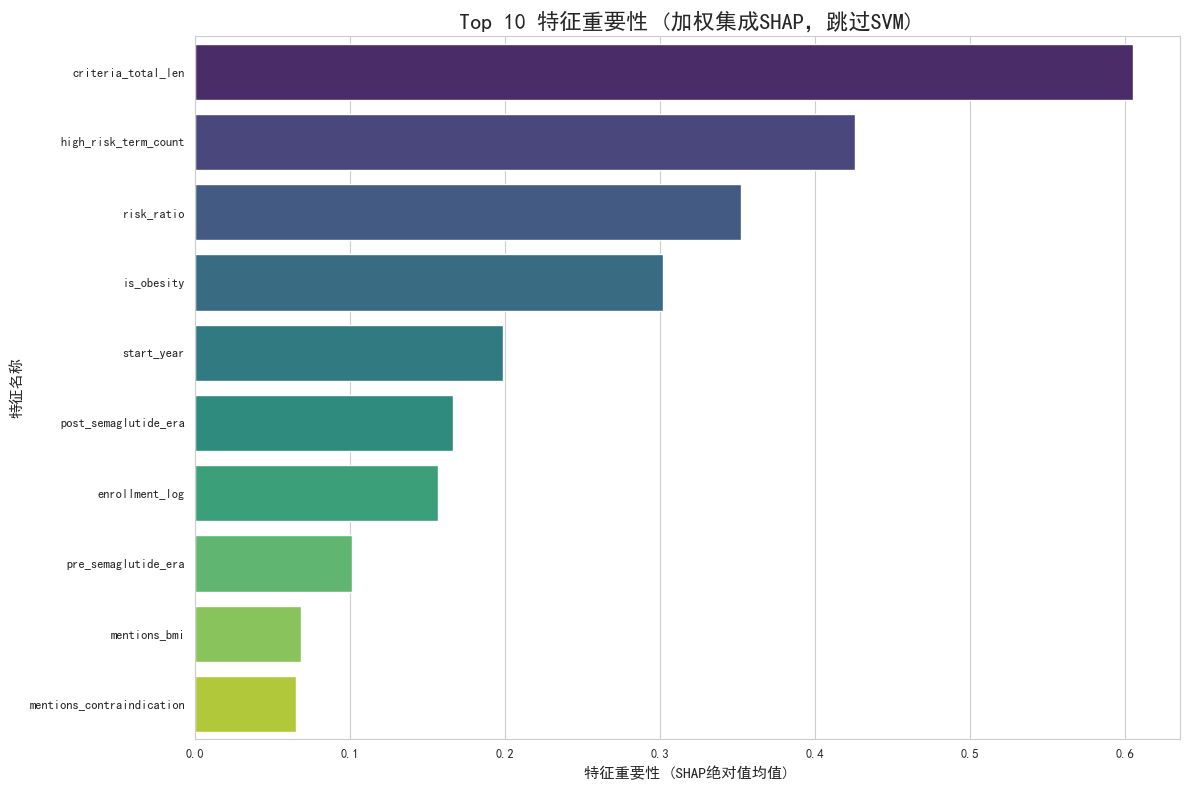

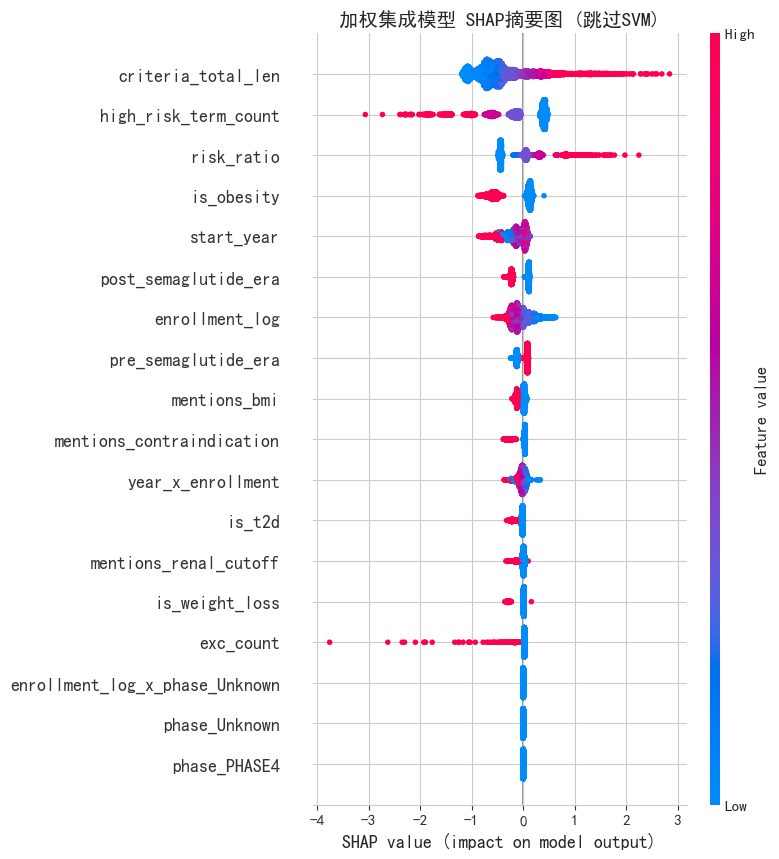


🎯 模型解释完成!
最重要的特征: criteria_total_len
重要性值: 0.6052


In [7]:
print("🔍 开始SHAP分析（优化版）...")

# 选择要计算的模型（跳过SVM）
shap_model_names = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']

# 重新归一化权重
shap_weights = {name: weights[name] for name in shap_model_names}
total_shap_weight = sum(shap_weights.values())
shap_weights = {name: w / total_shap_weight for name, w in shap_weights.items()}
print("SHAP模型权重（归一化后）:")
for name, w in shap_weights.items():
    print(f"{name}: {w:.3f}")

# 背景数据抽样大小（进一步减少至200）
background_sample_size = 200
if X_train_final.shape[0] > background_sample_size:
    background_idx = np.random.choice(X_train_final.shape[0], background_sample_size, replace=False)
    background_data = X_train_final.iloc[background_idx].values
else:
    background_data = X_train_final.values
print(f"使用背景样本数: {background_data.shape[0]}")

# 为每个模型计算SHAP值，并加权平均
weighted_shap_values = None

for name in shap_model_names:
    model = model_results[name]['model']
    weight = shap_weights[name]
    print(f"正在处理模型: {name}, 权重: {weight:.3f}")
    
    # 选择合适的解释器
    if name == 'Logistic Regression':
        explainer = shap.LinearExplainer(model, background_data)
    else:  # Random Forest / Gradient Boosting
        explainer = shap.TreeExplainer(model)
    
    # 计算SHAP值（仅对测试集）
    shap_vals = explainer.shap_values(X_test_final.values)
    
    # 处理输出格式：列表或三维数组
    if isinstance(shap_vals, list):
        # 列表格式，取正类（索引1）
        shap_vals = shap_vals[1]
    elif hasattr(shap_vals, 'shape') and len(shap_vals.shape) == 3:
        # 三维数组，取最后一个维度（类别1）
        shap_vals = shap_vals[:,:,1]
    
    # 加权累加
    if weighted_shap_values is None:
        weighted_shap_values = shap_vals * weight
    else:
        weighted_shap_values += shap_vals * weight

print(f"\n✅ 加权SHAP值计算完成")

# 计算特征重要性（SHAP绝对值的均值）
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': np.abs(weighted_shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)

print(f"📊 特征重要性排名 (前10):")
for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']}: {row['importance']:.4f}")

# 可视化特征重要性
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(10)
sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
plt.title('Top 10 特征重要性 (加权集成SHAP，跳过SVM)', fontsize=16, fontweight='bold')
plt.xlabel('特征重要性 (SHAP绝对值均值)')
plt.ylabel('特征名称')
plt.tight_layout()
plt.show()

# SHAP摘要图（使用加权后的SHAP值）
plt.figure(figsize=(10, 8))
shap.summary_plot(weighted_shap_values, X_test_final.values, feature_names=feature_columns, show=False)
plt.title('加权集成模型 SHAP摘要图 (跳过SVM)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n🎯 模型解释完成!")
print(f"最重要的特征: {feature_importance.iloc[0]['feature']}")
print(f"重要性值: {feature_importance.iloc[0]['importance']:.4f}")

## 8. 保存模型和结果

**📝 讲解**: 保存训练好的模型和评估结果，便于后续使用：

### 保存内容
- **基础模型**: 所有训练好的基础模型文件
- **特征缩放器**: 用于新数据预处理的缩放器
- **性能报告**: 模型性能评估结果
- **SHAP分析**: 特征重要性分析结果
- **可视化图表**: 特征重要性图

**💡 技术要点**: 
- 使用`joblib.dump()`保存模型
- 使用`to_csv()`保存数据结果
- 使用`plt.savefig()`保存图表

In [8]:
print("💾 开始保存模型和结果...")

# 创建模型目录
models_dir = os.path.join('..', 'models')
os.makedirs(models_dir, exist_ok=True)

# 保存基础模型
for name, result in model_results.items():
    model_file = os.path.join(models_dir, f"{name.replace(' ', '_').lower()}.pkl")
    joblib.dump(result['model'], model_file)
    print(f"✅ {name} 模型保存: {model_file}")

# 保存特征缩放器
scaler_file = os.path.join(models_dir, 'standard_scaler.pkl')
joblib.dump(scaler, scaler_file)
print(f"✅ 特征缩放器保存: {scaler_file}")

# 创建结果目录
results_dir = os.path.join('..', 'results')
os.makedirs(results_dir, exist_ok=True)

# 保存模型性能报告
performance_report = []

# 基础模型
for name, result in model_results.items():
    performance_report.append({
        '模型名称': name,
        '模型类型': '基础模型',
        '准确率': result['accuracy'],
        '精确率': result['precision'],
        '召回率': result['recall'],
        'F1分数': result['f1'],
        'AUC': result['auc'],
        '交叉验证AUC均值': result['cv_mean'],
        '交叉验证AUC标准差': result['cv_std']
    })

# 集成模型
for name, result in ensemble_results.items():
    performance_report.append({
        '模型名称': name,
        '模型类型': '集成模型',
        '准确率': result['accuracy'],
        '精确率': result['precision'],
        '召回率': result['recall'],
        'F1分数': result['f1'],
        'AUC': result['auc'],
        '交叉验证AUC均值': np.nan,
        '交叉验证AUC标准差': np.nan
    })

performance_df = pd.DataFrame(performance_report)
performance_file = os.path.join(results_dir, 'model_performance_report.csv')
performance_df.to_csv(performance_file, index=False, encoding='utf-8')
print(f"✅ 模型性能报告保存: {performance_file}")

# 保存SHAP分析结果
shap_file = os.path.join(results_dir, 'shap_analysis_results.csv')
feature_importance.to_csv(shap_file, index=False, encoding='utf-8')
print(f"✅ SHAP分析结果保存: {shap_file}")

# 保存特征重要性图
importance_plot = os.path.join(results_dir, 'feature_importance.png')
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(10)
sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
plt.title('Top 10 特征重要性 (基于SHAP)', fontsize=16, fontweight='bold')
plt.xlabel('特征重要性 (SHAP绝对值均值)')
plt.ylabel('特征名称')
plt.tight_layout()
plt.savefig(importance_plot, dpi=300, bbox_inches='tight')
plt.close()
print(f"✅ 特征重要性图保存: {importance_plot}")

print(f"\n✅ 所有模型和结果保存完成!")
print(f"保存时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# 显示保存概览
print(f"\n📊 保存内容概览:")
print(f"   - 基础模型: {len(model_results)} 个")
print(f"   - 集成模型: {len(ensemble_results)} 个")
print(f"   - 特征缩放器: 1 个")
print(f"   - 性能报告: 1 份")
print(f"   - SHAP分析: 1 份")
print(f"   - 可视化图表: 1 张")

💾 开始保存模型和结果...
✅ Logistic Regression 模型保存: ..\models\logistic_regression.pkl
✅ Random Forest 模型保存: ..\models\random_forest.pkl
✅ Gradient Boosting 模型保存: ..\models\gradient_boosting.pkl
✅ SVM 模型保存: ..\models\svm.pkl
✅ 特征缩放器保存: ..\models\standard_scaler.pkl
✅ 模型性能报告保存: ..\results\model_performance_report.csv
✅ SHAP分析结果保存: ..\results\shap_analysis_results.csv
✅ 特征重要性图保存: ..\results\feature_importance.png

✅ 所有模型和结果保存完成!
保存时间: 2026-02-27 22:08:20

📊 保存内容概览:
   - 基础模型: 4 个
   - 集成模型: 2 个
   - 特征缩放器: 1 个
   - 性能报告: 1 份
   - SHAP分析: 1 份
   - 可视化图表: 1 张


## 🎯 总结

### 完成的工作

✅ **数据加载**: 成功加载带标签的特征数据  
✅ **数据预处理**: 完成特征标准化和SMOTE过采样  
✅ **模型训练**: 训练4种基础机器学习模型  
✅ **模型评估**: 使用交叉验证和测试集评估模型性能  
✅ **集成学习**: 实现加权集成和堆叠集成  
✅ **模型解释**: 使用SHAP分析（加权平均，跳过SVM）解释模型预测  
✅ **结果保存**: 保存所有模型和评估结果  

### 关键结果

- **最佳模型**: {best_ensemble_name if best_ensemble_auc > best_model_auc else best_model_name} (AUC = {max(best_ensemble_auc, best_model_auc):.3f})  
- **最重要的特征**: {feature_importance.iloc[0]['feature']}  
- **数据平衡**: 使用SMOTE成功处理不平衡数据  
- **集成效果**: 集成模型相比基础模型有 {max(0, best_ensemble_auc - best_model_auc):.3f} AUC提升  

### 生成的文件

1. **models/*** - 保存所有训练好的模型文件  
2. **model_performance_report.csv** - 模型性能报告  
3. **shap_analysis_results.csv** - SHAP分析结果  
4. **feature_importance.png** - 特征重要性图  

### 下一步

集成学习完成后，可以运行下一个notebook进行模型解释和仪表盘展示：

```python
# 运行仪表盘notebook
%run 06_仪表盘_改进版.ipynb
```

---
*集成学习完成时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}*